# **Тестовое задание**
на  позицию **«Игровой / Маркетинговый аналитик» (Junior)**


Компания: **______________**   

Исполнитель: **Игорь Сасимович**   
* E-mail: ihar.sasimovich@gmail.com
* Telegram: http://t.me/ihar367

* Ссылка на резюме: https://drive.google.com/file/d/1EBLgL8GnqAjtnzZUc_0r5z2idgxOXZST/view?usp=drive_link
* Ссылка на портфолио: https://github.com/i-sasimovich/data_analytics_portfolio

# Задание

Представьте, что к вам обратился ваш коллега Богдан – менеджер по закупке рекламного трафика, с просьбой проанализировать данные рекламных кампаний, привлекавших пользователей в **январе 2021** года с одного из каналов. 

Он планирует запуск новых рекламных кампаний на те же регионы, и необходимо определить некоторые ключевые показатели, опираясь на которые он смог бы понимать, успешны ли будут новые кампании. Он просит вас:

* Определить оптимальный срок окупаемости рекламных кампаний.
* Рассчитать накопительный ARPU (average revenue per user) самой успешной рекламной кампании, оптимизированных под покупки, на 7, 14, 30 день жизни аккаунтов.

Вы уже выгрузили из базы необходимые файлы в формате .csv самостоятельно. Данные кажутся вам странными, поэтому вы решаете провести EDA, проверить  адекватность, предобработать перед началом расчетов. 
Ваш коллега передал вам свой отчет о рекламном бюджете за январь 2021 года в формате .xls.    

Богдан рассчитывает получить:
* файл с отчетом, в котором будут ответы на все его вопросы с визуализациями и комментариями. Формат на ваше усмотрение, но помните, что Богдан не владеет Python;   
* файл с предобработкой и расчетами в формате .ipynb.

Если вы можете предложить дополнительно какие-то метрики для оценки успешности кампаний на ранних стадиях (не дожидаясь достижения срока окупаемости), можете их описать с обоснованием и предоставить расчет - будет большим плюсом.


### Данные: 

Файлы для выполнения задания:

* <span style="color:#FF6861"> **«registrations.csv»**</span> – регистрации аккаунтов за январь 2021 год с одного из каналов. Описание данных:
    * account_id – ID аккаунта;
    * created_date – дата создания аккаунта;
    * campaign – рекламная кампания, с которой пришел пользователь


* <span style="color:#FF6861"> **«payments.csv»**</span>  – платежи пользователей одного из каналов за 2021 год. Описание данных:
    * payment_date – дата оплаты
    * payment_types – типы платежных систем;
    * real_cost – сконвертированная сумма платежа;
    * account_id - ID аккаунта.

* <span style="color:#FF6861"> **«persents.csv»**</span> – комиссии платежных систем. Описание данных:
    * payment_types – типы платежных систем;
    * Share, %  - комиссия платежной системы.

* <span style="color:#FF6861"> **«ad_budget_jan_2021.xlsx**»</span> (переименованный Рекламный бюджет январь 2021.xlsx) - бюджет на рекламу в январе 2021 года. Описание данных:
    * media_source – рекламная сеть;
    * Campaign_type – тип рекламной кампании;
    * Target – регион, на который направлена рекламная кампания;
    * Plan, USD – планируемый бюджет;
    * Installs – фактическое количество установок;
    * Spend, USD – фактически потраченный бюджет;
    * Deviation, USD – отклонение от плана.
-----

# **EDA**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## ad_budget_jan_2021.xlsx

Поскольку я пока не являюсь сотрудником AIGRIND и не обладаю полным контекстом, считаю логичным начать с анализа рекламного бюджета, который задаёт рамки и помогает понять, какие кампании продвигались, какие каналы использовались и как распределялись средства.   
Это поможет лучше ориентироваться при дальнейшем изучении предоставленных датасетов.

In [2]:
budget_df = pd.read_excel(r"D:\000_Jupyter_notebooks\05. Test-Tasks\2025 06 AiGrind\ad_budget_jan_2021.xlsx", 
                         sheet_name='budget')

# Интерполируем пропущенные значения
budget_df['media_source'] = budget_df.media_source.ffill()

# Удалим итого
budget_df.drop(index=8, inplace=True)

# Создадим колонку "tag".
budget_df['tag'] = budget_df['Target'].str[:3].str.upper() + '_MS' + budget_df['media_source'].str[-1] + '_' + budget_df['Campaign_type']

# Приводим названия колонок к единому стилю
budget_df = budget_df.rename(columns={
    'media_source': 'media_source',
    'Campaign_type': 'campaign_type',
    'Target': 'target_region',
    'tag': 'tag',
    'Plan, USD': 'plan',
    'Installs': 'bogdan_installs',
    'Spend, USD': 'spend_actual',
    'Deviation, USD': 'deviation'    
})

# Сразу рассчитаем CPI. Почему 'bogdan_cpi' и 'bogdan_installs'? Сначала было просто 'cpi', но в дальнейшем выяснится расхождение в подсчёте количества регистраций. 
budget_df['bogdan_cpi'] = (budget_df['spend_actual'] / budget_df['bogdan_installs']).round(3)

# Слегка изменим порядок колонок для читаемости и удобства последующего анализа
budget_df = budget_df[['media_source', 'campaign_type', 'target_region', 'tag', 'plan', 'spend_actual', 'deviation', 'bogdan_installs', 'bogdan_cpi']]

budget_df

,media_source,campaign_type,target_region,tag,plan,spend_actual,deviation,bogdan_installs,bogdan_cpi
0,Media_source_1,install,Brazil,BRA_MS1_install,100,99.12,0.88,10460,0.009
1,Media_source_1,purchase,Brazil,BRA_MS1_purchase,400,398.67,1.33,1081,0.369
2,Media_source_1,install,Russia,RUS_MS1_install,200,246.30,-46.30,11894,0.021
3,Media_source_1,purchase,Russia,RUS_MS1_purchase,500,616.77,-116.77,1441,0.428
4,Media_source_1,install,Ukrane,UKR_MS1_install,100,99.43,0.57,6424,0.015
5,Media_source_1,purchase,Ukrane,UKR_MS1_purchase,500,348.13,151.87,242,1.439
6,Media_source_2,install,Brazil,BRA_MS2_install,100,81.15,18.85,152,0.534
7,Media_source_2,install,English_speaking,ENG_MS2_install,100,99.95,0.05,371,0.269


In [3]:
# Пересчитаем total
total = (
    f"Plan: {budget_df['plan'].sum()} \n"
    f"Spend: {budget_df['spend_actual'].sum()} \n"
    f"Installs: {budget_df['bogdan_installs'].sum()}"
)

print(total)

Plan: 2000 
Spend: 1989.52 
Installs: 32065


Итак: 

* Всего **8** рекламных кампаний.
* Общий бюджет: 2 000 $ плановых расходов, фактически израсходовано 1 989.52  - укладываемся в план с минимальным отклонением.
* Фактическое число установок (по версии Богдана): **32 065**.

Самый низкий CPI (по версии Богдана):
* Media_source_1, install:
    * Brazil: 0.009 $.
    * Ukraine: 0.015 $.
    * Russia: 0.021 $.

Самый дорогой CPI (по версии Богдана):
* Media_source_1, purchase:
    * Ukraine: 1.439 $.
    * Russia: 0.428 $.

Перейдём к регистрациям.

<br>

## registrations.csv

In [4]:
# Данные по регистрации пользователей
reg_df = pd.read_csv(r"D:\000_Jupyter_notebooks\05. Test-Tasks\2025 06 AiGrind\registrations.csv", parse_dates=['created_date'])

# Избавимся от индекса, сохраненного при при экспорте.
reg_df = reg_df.drop(columns=['Unnamed: 0']) 

reg_df.head()

,account_id,created_date,campaign
0,3842380.0,2021-01-01,BRA_MS1_install
1,3842381.0,2021-01-01,NaN
2,3842382.0,2021-01-01,NaN
3,3842383.0,2021-01-01,NaN
4,3842384.0,2021-01-01,BRA_MS1_install


In [5]:
# Посмотрим краткую сводную информации о DataFrame. 
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89144 entries, 0 to 89143
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   account_id    89141 non-null  float64       
 1   created_date  89144 non-null  datetime64[ns]
 2   campaign      36283 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.0+ MB


In [6]:
# Посмотрим на временные рамки исследуемого периода: 
print(f"Начало исследуемого периода: {reg_df.created_date.min()}.\nКонец исследуемого периода: {reg_df.created_date.max()}.")

Начало исследуемого периода: 2021-01-01 00:00:00.
Конец исследуемого периода: 2021-01-31 00:00:00.


Что мы видим:
1. Тип данных "account_id" - float64. 
2. Общее количество строк 89144, записей в "created_date" 89144, а в "account_id" 89141 ⚠️, в  "campaign" 36283 ⚠️.
3. ⚠️🚨 Все пользователи действительно зарегистрированы в январе 2021. Однако, возможно была допущена ошибка при выгрузке данных. '2021-01-31 00:00:00' - это только ровно полночь 31 числа, а все события в течение дня 31.01 могли оказаться за пределами фильтра. Т.е. фактически данные не включают регистрации совершённые за сутки 31 января 2021. 

Поссмотрим на количество пропущенных значений. Проверим на дубликаты.

In [7]:
reg_df.isna().sum()

account_id          3
created_date        0
campaign        52861
dtype: int64

In [8]:
reg_df.duplicated().sum()

0

Дубликатов нет.

52861 пропущенных значений в колонке "campaign" - вероятно, органика. Конечно, может быть и ситуация, когда данные не были просто зафиксированы системой или метка кампании потерялась из-за технического сбоя, интеграционного бага или неполной передачи данных. Но это, на имеющихся данных, мы никак не проверим. Поэтому, сразу избавимся от таких записей.

А вот в колонке "account_id" не должно быть пропущенных значений, но они есть.

In [9]:
reg_df = reg_df[reg_df['campaign'].notna()]

In [10]:
# Отберём строки с NaN в account_id. 
reg_df[reg_df['account_id'].isna()]

,account_id,created_date,campaign


Вопрос с колонкой "account_id" отпал сам собой после удаления органических установок 😅

Приведём колонку "account_id" к целочисленному типу данных.

In [11]:
reg_df['account_id'] = reg_df['account_id'].astype('Int64')
reg_df.shape

(36283, 3)

Количество регистраций всё ещё не сходится с количеством регистраций по версии Богдана.

Посмотрим на количество рекламных кампаний. 

In [12]:
reg_df.campaign.nunique()

10

In [13]:
reg_df.campaign.unique()

array(['BRA_MS1_install', 'RUS_MS1_install', 'UKR_MS1_install',
       'BRA_MS1_purchase', 'RUS_MS1_purchase', 'PR_youtube_bloger',
       'UKR_MS1_purchase', 'ENG_MS2_install', 'BRA_MS2_install', 'our_fb'],
      dtype=object)

В файле регистрации встречаются метки 10 кампаний, **в бюджете их 8**. 

PR_youtube_bloger и our_fb - не указаны в бюджете, а значит нас в данном анализе не интересуют. Уберём их.

In [14]:
reg_df = reg_df.query("campaign not in ['PR_youtube_bloger', 'our_fb']").reset_index(drop=True)
reg_df.shape

(34440, 3)

Посмотрим на количество регистраций по кампаниям и сравним их со значениями указанными в бюджете: 

In [15]:
campaign_counts_df = reg_df.campaign.value_counts(dropna=False).reset_index(name='real_installs')

# Смёрждим с установками из budget_df
campaign_counts_df = (
    campaign_counts_df
    .merge(
        budget_df[['tag', 'bogdan_installs']].dropna(),
        left_on='campaign',
        right_on='tag',
        how='inner'
    ).drop(columns='tag'))


# Рассчитаем отклонения
campaign_counts_df['deviation'] = (campaign_counts_df.real_installs - campaign_counts_df.bogdan_installs)


# Добавим строку с итогами:

total_row = {
    'campaign': 'Total',
    'real_installs': campaign_counts_df['real_installs'].sum(),
    'bogdan_installs': campaign_counts_df['bogdan_installs'].sum(),
    'deviation': campaign_counts_df['deviation'].sum()
}

# Добавляем как новую строку
campaign_counts_df = pd.concat(
    [campaign_counts_df, pd.DataFrame([total_row])],
    ignore_index=True
)

campaign_counts_df

,campaign,real_installs,bogdan_installs,deviation
0,RUS_MS1_install,12649,11894,755
1,BRA_MS1_install,11462,10460,1002
2,UKR_MS1_install,6790,6424,366
3,RUS_MS1_purchase,1581,1441,140
4,BRA_MS1_purchase,1139,1081,58
5,ENG_MS2_install,407,371,36
6,UKR_MS1_purchase,260,242,18
7,BRA_MS2_install,152,152,0
8,Total,34440,32065,2375


🚨 ⚠️ При сопоставлении данных из Excel-отчёта «Рекламный бюджет январь 2021.xlsx» и фактических регистраций из registrations.csv, было выявлено расхождение в количестве установок по кампаниям.
Кто-то из нас ошибается: либо я, либо Богдан.  Думаю, в рабочем процессе мы бы спокойно всё сверили и нашли источник расхождения.

А в рамках тестового задания - буду опираться на свои расчёты. **Соответственно, в дальнейшем необходимо будет пересчитать CPI.**

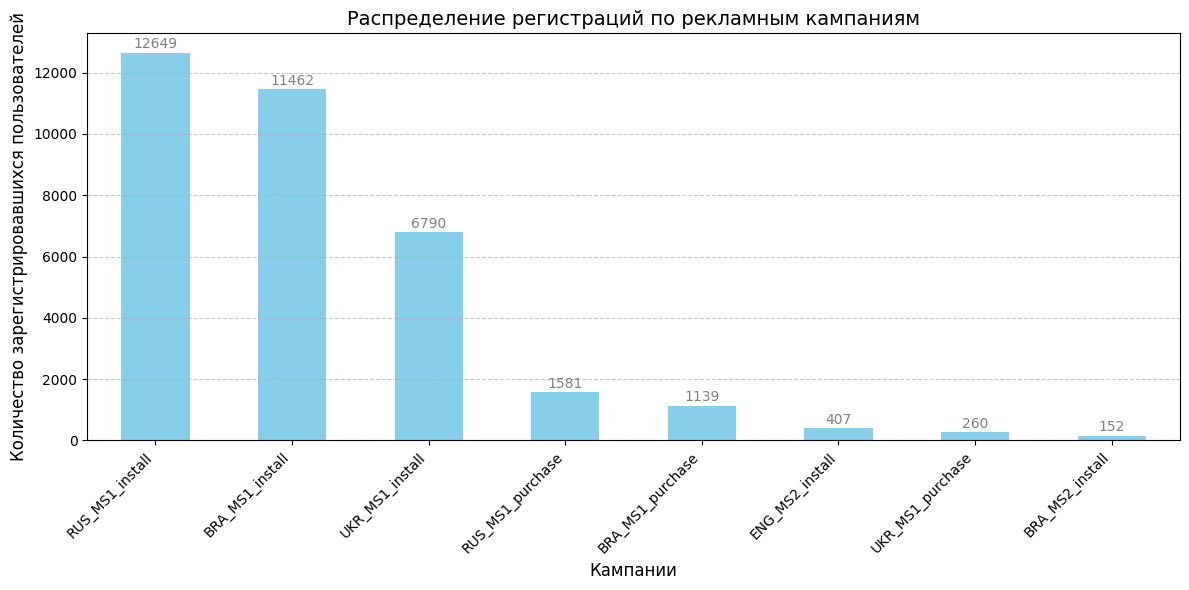

In [16]:
# Визуализируем. 
ax = reg_df.campaign.value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=1, color = 'Gray')

plt.title('Распределение регистраций по рекламным кампаниям', fontsize=14)
plt.xlabel('Кампании', fontsize=12)
plt.ylabel('Количество зарегистрировавшихся пользователей', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

В анализ включены **34 440** пользователя, пришедшие по явно отмеченным рекламным кампаниям. При этом основной трафик **(более 89% / 30 901 юзер)** распределяется между тремя ключевыми кампаниями:

* RUS_MS1_install - 12 649 (36,7%)

* BRA_MS1_install - 11 462 (33%)

* UKR_MS1_install - 6 790 (19,7%)

Остальные 5 кампаний составляют долю менее 11%.

### Посмотрим на динамику регистраций по кампаниям

Чтобы избежать перегрузки графика и сфокусироваться на наиболее значимых кампаниях, в рамках выполнения данного тестового, я визуализирую ТОП-3 рекламные кампании, оптимизированные под установки, и отдельно кампании, оптимизированные под покупки.

In [17]:
top_3_innstall_campaigns= reg_df[reg_df['campaign'].isin(['RUS_MS1_install', 'BRA_MS1_install', 'UKR_MS1_install'])]

In [18]:
# Сгруппируем данные по дате и кампании
daily_counts = top_3_innstall_campaigns.groupby(['created_date', 'campaign']).size().unstack(fill_value=0)


# Посмотрим описательные статистики
daily_counts.describe().round(2)

campaign,BRA_MS1_install,RUS_MS1_install,UKR_MS1_install
count,31.00,31.00,31.00
mean,369.74,408.03,219.03
std,78.60,94.98,38.34
min,210.00,193.00,131.00
25%,312.00,360.00,197.50
50%,346.00,397.00,211.00
75%,432.00,460.50,238.50
max,540.00,585.00,327.00


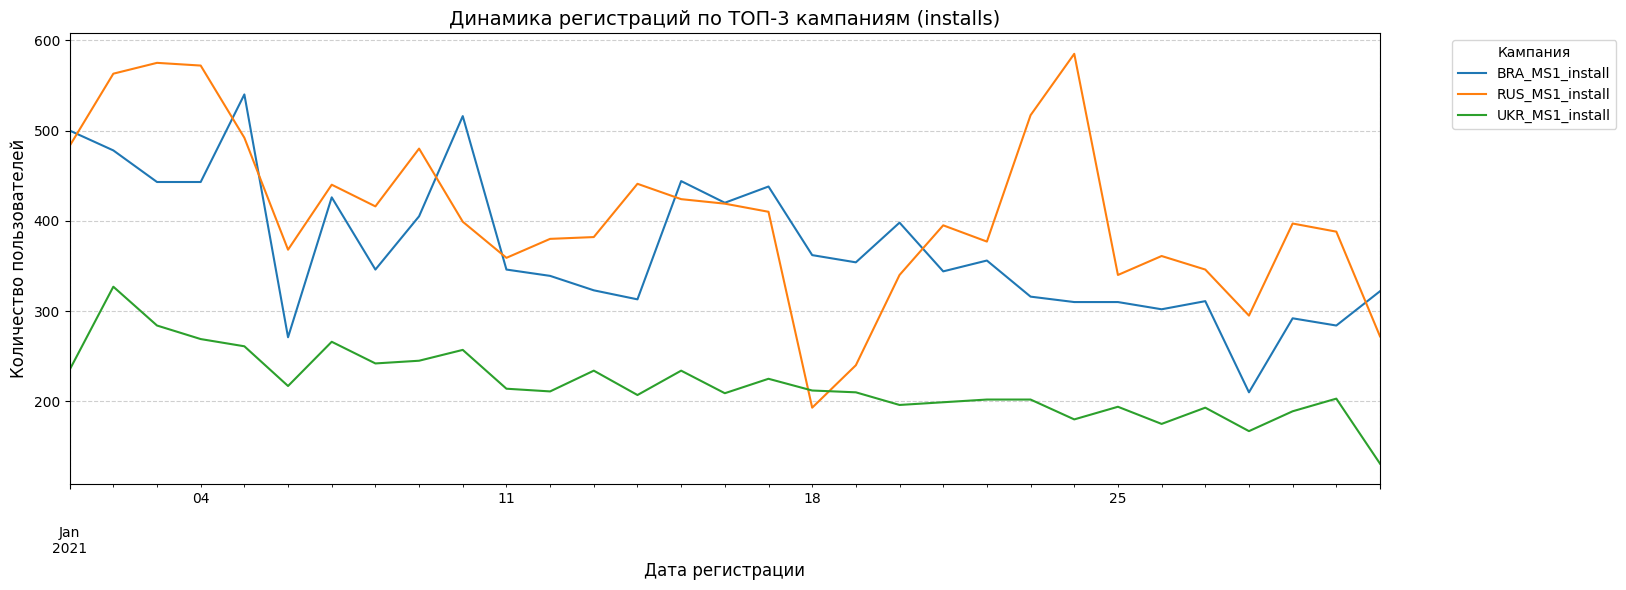

In [19]:
# Строим линейный график
daily_counts.plot(kind='line', figsize=(14, 6))

plt.title('Динамика регистраций по ТОП-3 кампаниям (installs)', fontsize=14)
plt.xlabel('Дата регистрации', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Кампания', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Что видим: 

<span style="color:#ffaa61"> **RUS_MS1_install**</span> показывает высокий потенциал привлечения -наивысшее среднее значение регистраций (408) и максимум (585). Однако высокая изменчивость (std = 94.98) указывает на нестабильность - вероятно, кампания чувствительна к внешним условиям (дни недели, конкуренция в аукционах, особенности креативов).    
Стоит изучить пики и выявить, что именно сработало в эти дни.
Стоит обратить внимание на резкий спад **18 января и пик 24 января**.

<span style="color:#4169E1"> **BRA_MS1_install**</span> выступает как наиболее сбалансированная кампания: хороший уровень средних регистраций (369), относительно высокая максимальная эффективность (540) и умеренная волатильность (std = 78.60). Подходит для устойчивого масштабирования при контролируемом уровне риска.

<span style="color:#228B22"> **UKR_MS1_install**</span> - самая «ровная», но наименее результативная кампания: среднее значение регистраций в два раза ниже, чем у RUS_MS1_install (219 vs 408), но и наименьшее отклонение (std = 38.34), что делает её более предсказуемой, хоть и неэффективной. Возможно, имеет смысл проанализировать особенности целевой аудитории, креативы и каналы продвижения для отдельной кампании, проверить: не завышены ли ожидания от региона, верно ли выбран таргетинг и не требуется ли полный пересмотр подхода..

⚠️ Пики и спады стоит проанализировать подробнее - в этих аномалиях могут скрываться важные инсайты.

⚠️ Важно отметить, что количество регистраций - это лишь один из KPI.  Для оценки эффективности кампаний необходимо дополнительно учитывать **качество** регистраций и их конверсию в целевые действия (например, покупки, просмотр рекламы).

<br>

Теперь по аналогии посмотрим на кампании, оптимизированные под покупки. 

In [20]:
purchase_campaigns = reg_df[reg_df['campaign'].isin(budget_df.query("campaign_type == 'purchase'")['tag'].tolist())]

In [21]:
purchase_daily_counts = purchase_campaigns.groupby(['created_date', 'campaign']).size().unstack(fill_value=0)

In [22]:
# Посмотрим описательные статистики
purchase_daily_counts.describe().round(2)

campaign,BRA_MS1_purchase,RUS_MS1_purchase,UKR_MS1_purchase
count,31.00,31.0,31.00
mean,36.74,51.0,8.39
std,12.83,18.6,4.79
min,13.00,18.0,2.00
25%,24.50,38.5,5.50
50%,36.00,49.0,7.00
75%,48.00,57.5,10.50
max,57.00,104.0,22.00


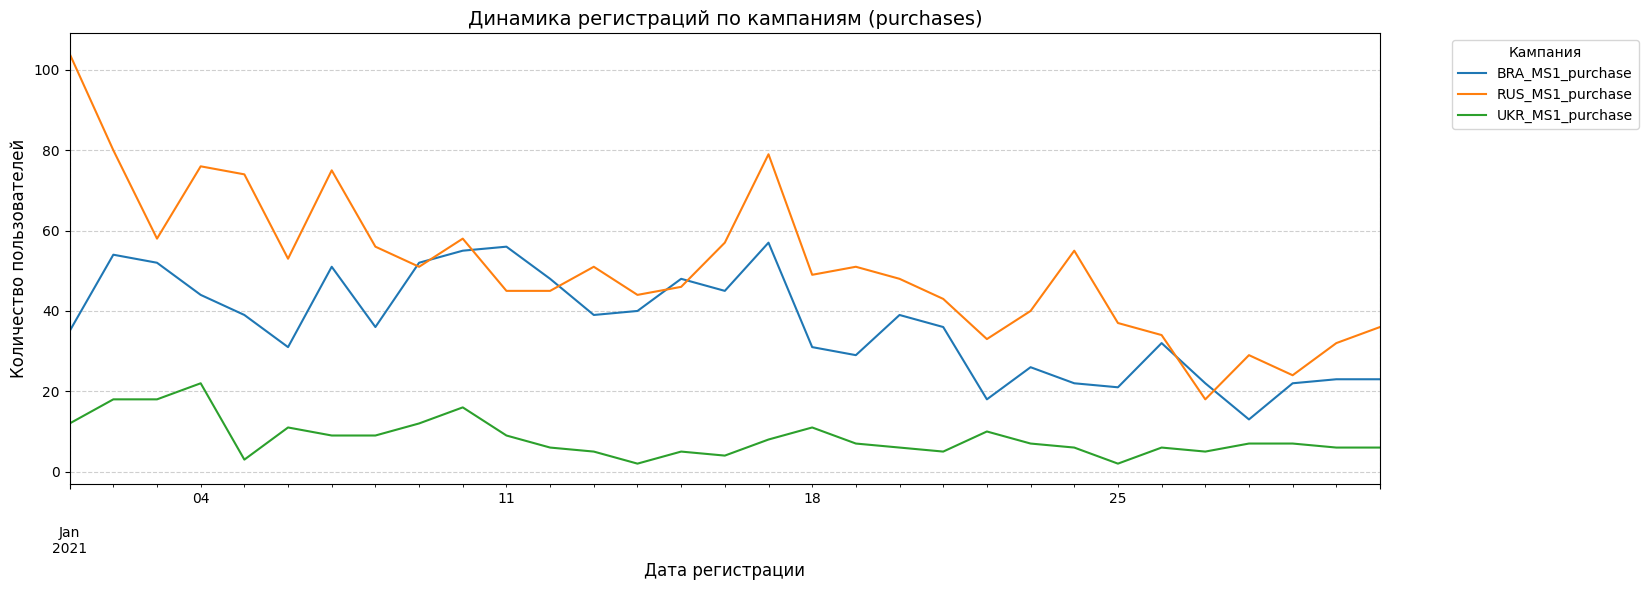

In [23]:
# Строим линейный график
purchase_daily_counts.plot(kind='line', figsize=(14, 6))

plt.title('Динамика регистраций по кампаниям (purchases)', fontsize=14)
plt.xlabel('Дата регистрации', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Кампания', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Что видим: 

<span style="color:#ffaa61"> **RUS_MS1_purchase**</span>. 

Наивысший средний уровень регистраций -- 51 пользователь в день.

Максимум -- 104, почти в два раза выше, чем у остальных кампаний.

Однако относительно высокая волатильность (std = 18.6) требует пристального внимания: стоит исследовать природу всплесков, особенно вблизи **17–20 и 26–28 января**.


<span style="color:#4169E1"> **BRA_MS1_purchase**</span> 

Наиболее сбалансированная: среднее значение -- 36.74, отклонение -- 12.83.

Более сбалансированная кампания без чрезмерно выраженных резких спадов, максимум достигает 57.


<span style="color:#228B22"> **UKR_MS1_purchase**</span>

Наиболее стабильная (std = 4.79), но в то же время наименее результативная кампания по привлечению пользователей: среднее значение всего 8.39, максимум -- 22.

Повторюсь:

⚠️ Пики и спады стоит проанализировать подробнее - в этих аномалиях могут скрываться важные инсайты.

⚠️ Важно отметить, что количество регистраций - это лишь один из KPI.  Для оценки эффективности кампаний необходимо дополнительно учитывать **качество** регистраций и их конверсию в целевые действия (например, покупки, просмотр рекламы).

<br>

## persents.csv

Перед тем как приступить к анализу платежей, проанализируем комиссии, указанные в persents.csv. Эти данные пригодятся нам для расчёта чистого дохода.

In [24]:
persents_df = pd.read_csv(r"D:\000_Jupyter_notebooks\05. Test-Tasks\2025 06 AiGrind\persents.csv")

#Переименуем для удобства 
persents_df = persents_df.drop(columns=['Unnamed: 0']).rename(columns={'Payment_types':'payment_types', 'Share, %':'payment_fee_rate'}) 
persents_df.head()

,payment_types,payment_fee_rate
0,Payment_system_1,20.7
1,Payment_system_2,15.0
2,Payment_system_3,58.5
3,Payment_system_4,0.0
4,Payment_system_5,24.0


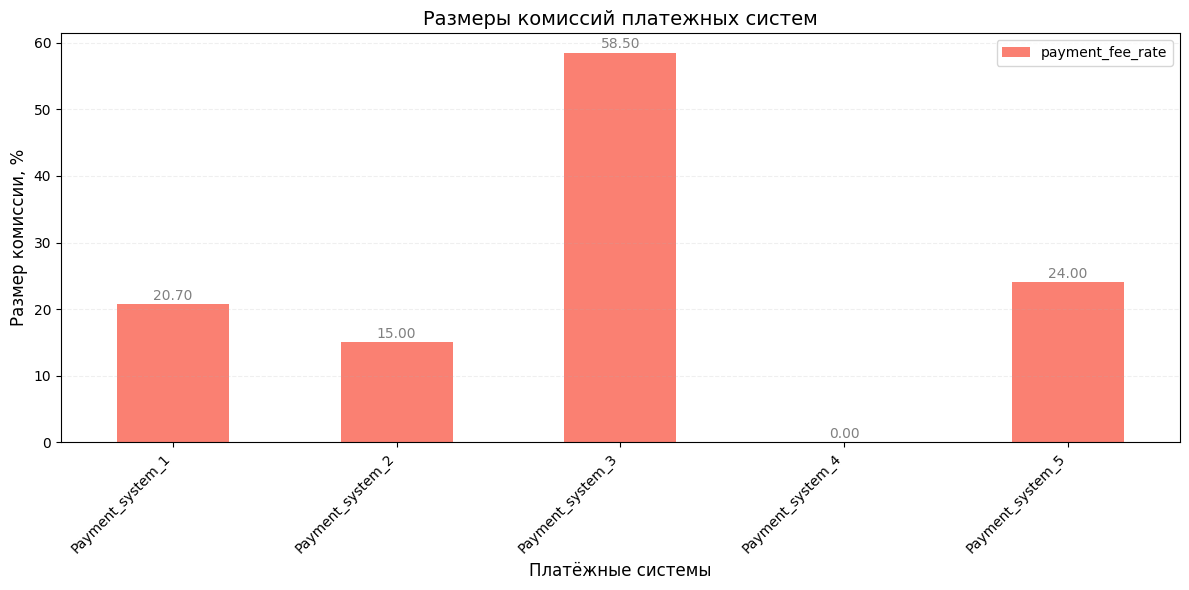

In [25]:
ax = persents_df.plot(
    kind='bar', 
    x='payment_types', 
    y='payment_fee_rate', 
    figsize=(12, 6), 
    color='salmon'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=1, color='Grey')

plt.title('Размеры комиссий платежных систем', fontsize=14)
plt.xlabel('Платёжные системы', fontsize=12)
plt.ylabel('Размер комиссии, %', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

Payment_system_3 взимает самую высокую комиссию -- 58.5%, что может ограничивать её привлекательность. 

Payment_system_5 и Payment_system_1 установили комиссии на уровне 24.0% и 20.7% соответственно - тоже довольно высокие значения. Payment_system_2 предлагает более щадящие условия с комиссией 15.0%. 

Payment_system_4 указана с нулевой комиссией -- что либо отражает уникальную стратегию привлечения, либо свидетельствует об ошибке в исходных данных. Требуется дополнительная проверка.

<br>

## payments.csv

In [26]:
pmt_df = pd.read_csv(r"D:\000_Jupyter_notebooks\05. Test-Tasks\2025 06 AiGrind\payments.csv", parse_dates=['payment_date'])

# Переименуем столбцы для унификации и читаемости.
# Заменим'real_cost' на 'payment_amount' - название лучше отражает суть: сумма поступившего платежа (до вычета комиссии).
pmt_df.rename(columns={'Payment_types':'payment_types', 'real_cost':'payment_amount'}, inplace=True)
pmt_df.head()

,payment_date,payment_types,payment_amount,account_id
0,2021-01-01 00:00:56,Payment_system_5,9.650000,2907221
1,2021-01-01 00:01:48,Payment_system_5,0.955872,3228373
2,2021-01-01 00:03:42,Payment_system_5,3.026930,318552
3,2021-01-01 00:04:27,Payment_system_2,99.990000,3832817
4,2021-01-01 00:06:41,Payment_system_5,1.432550,7229767


In [27]:
# Общая информация о DataFrame
pmt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303614 entries, 0 to 303613
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   payment_date    303614 non-null  datetime64[ns]
 1   payment_types   303614 non-null  object        
 2   payment_amount  303614 non-null  float64       
 3   account_id      303614 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 9.3+ MB


Пропущенных значений нет. 

Типы данных в порядке.



In [28]:
# Проверим наличие полных дубликатов строк в платежных данных
pmt_df.duplicated().sum()

4

In [29]:
# Посмотрим на них и оригиналы
pmt_df[pmt_df.duplicated(keep=False)]

,payment_date,payment_types,payment_amount,account_id
35707,2021-02-15 14:40:13,Payment_system_3,1.99,1827251
35708,2021-02-15 14:40:13,Payment_system_3,1.99,1827251
43292,2021-02-26 17:35:31,Payment_system_5,45.20,3945214
43293,2021-02-26 17:35:31,Payment_system_5,45.20,3945214
262704,2021-11-15 16:12:44,Payment_system_4,0.47,4720239
262705,2021-11-15 16:12:44,Payment_system_4,0.47,4720239
268377,2021-11-21 03:22:42,Payment_system_2,62.00,8768141
268378,2021-11-21 03:22:42,Payment_system_2,62.00,8768141


Итак, в данных обнаружено 4 полных дубликата. Все поля совпадают, включая метку времени до секунды. Это может указывать на техническое задвоение записей при сохранении транзакций, либо - менее вероятно, но возможно - на повторный платёж, ошибочно зафиксированный с теми же параметрами.

Контекста недостаточно для точной интерпретации. В рамках реального проекта я бы уточнил природу дубликатов у коллег, ответственных за сбор и хранение платёжных данных.

В текущем задании, исходя из полной идентичности записей, считаю разумным трактовать их как задвоенные транзакции и удалить.

⚠️ Важно: в рабочей БД, как правило, используется уникальный идентификатор транзакции (transaction_id), который, отсутствует в данном срезе и мог бы помочь более точно определить источник проблемы.

In [30]:
# Удалим дубликаты
pmt_df = pmt_df.drop_duplicates().reset_index(drop = True)

In [31]:
# Округлим суммы платежей до сотых
pmt_df['payment_amount'] = pmt_df.payment_amount.round(2)
pmt_df.head(2)

,payment_date,payment_types,payment_amount,account_id
0,2021-01-01 00:00:56,Payment_system_5,9.65,2907221
1,2021-01-01 00:01:48,Payment_system_5,0.96,3228373


Проверим данный df на нарушение логики.

In [32]:
# проверим на отрицательные суммы платежей
pmt_df[pmt_df['payment_amount'] < 0].shape[0]

0

In [33]:
# проверим на нулевые суммы платежей
pmt_df[pmt_df['payment_amount'] == 0].shape[0]

20

🚨 Видим явное нарушение логики. Есть 20 транзакций с размером платежа равным нулю. 

⚠️ Выглядит как сбой или аномалия в данных. Нужно разбираться!

Так как таких записей немного, посмотрим на них глазами.

In [34]:
zero_pmt_df = pmt_df[pmt_df['payment_amount'] == 0]

zero_pmt_df

,payment_date,payment_types,payment_amount,account_id
143,2021-01-01 07:12:46,Payment_system_5,0.0,3843181
144,2021-01-01 07:22:46,Payment_system_5,0.0,3843200
145,2021-01-01 07:24:56,Payment_system_5,0.0,3843200
148,2021-01-01 07:33:20,Payment_system_5,0.0,3843200
164,2021-01-01 08:13:35,Payment_system_5,0.0,3843282
18117,2021-01-22 21:41:27,Payment_system_5,0.0,7839674
20661,2021-01-25 13:21:27,Payment_system_5,0.0,3915919
20671,2021-01-25 14:13:18,Payment_system_5,0.0,3915919
20672,2021-01-25 14:14:08,Payment_system_5,0.0,3915919
20676,2021-01-25 14:17:42,Payment_system_5,0.0,3915919


Видим, что все нулевые транзакции относятся к Payment_system_5. Возможно, ошибка сбора данных или другой технический сбой. Нужно разбираться. Нужно больше информации.

В рамках тестового, избавимся от таких значений.

In [35]:
pmt_df = pmt_df[pmt_df['payment_amount'] != 0]

In [36]:
pmt_df.shape[0]

303590

В payments.csv могут содержаться все транзакции: как от пользователей, привлечённых через маркетинг в январе 2021, так и от других - зарегистрированных до/после, или пришедших органически.

Нам нужны только платежи от пользователей, которые зарегистрировались в январе 2021 в рамках маркетинговых кампаний. 

In [37]:
payers_with_tracked_campaigns = pmt_df[pmt_df['account_id'].isin(reg_df[reg_df['campaign'].notna()].account_id)]
payers_with_tracked_campaigns.shape[0]

688

In [38]:
# Количество платящих пользователей
payers_with_tracked_campaigns.account_id.nunique()

198

In [39]:
print(f"Начало исследуемого периода: {payers_with_tracked_campaigns.payment_date.min()}.\nКонец исследуемого периода: {payers_with_tracked_campaigns.payment_date.max()}.")

Начало исследуемого периода: 2021-01-01 15:10:26.
Конец исследуемого периода: 2021-12-31 20:58:48.


Получается, всего 688 транзакций было совершено 198 пользователями, зарегистрировавшимися в январе 2021 года и связанными с нашими маркетинговыми кампаниями.

Всего 688 из 303 590 транзакций 🙁.

<br>

Посмотрим на распределение платежей по платёжным системам.

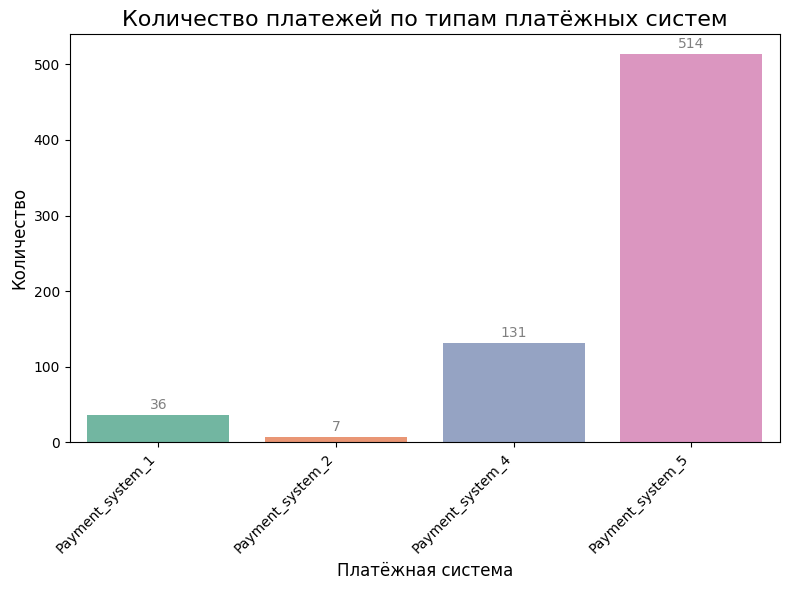

In [40]:
# Визуализируем
payments_by_system = payers_with_tracked_campaigns.groupby(['payment_types'])['account_id'].count().reset_index(name='count')

plt.figure(figsize=(8, 6))
ax = sns.barplot(payments_by_system, x='payment_types', y='count', hue='payment_types', palette='Set2', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2, color='Grey')

plt.title('Количество платежей по типам платёжных систем', fontsize=16)
plt.xlabel('Платёжная система', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Наблюдается явное преобладание Payment_system_5, несмотря на довольно высокую комиссию в 24%. Это может указывать на высокую популярность, возможно, благодаря удобству, репутации или региональным предпочтениям.

Также активно используется Payment_system_4, которая работает без комиссии - это делает её особенно выгодной с точки зрения прибыли.

Остальные платёжные системы используются заметно реже, а Payment_system_3 вообще не была задействована - что, вероятно, связано с крайне высокой комиссией 58.5%, делая её экономически нецелесообразной.

In [41]:
# Посмотрим описательные статистики колонки real_cost
payers_with_tracked_campaigns['payment_amount'].describe().round(2)

count    688.00
mean       6.66
std       10.44
min        0.01
25%        0.82
50%        2.62
75%        6.34
max       67.25
Name: payment_amount, dtype: float64

 Визуализируем распределение платежей


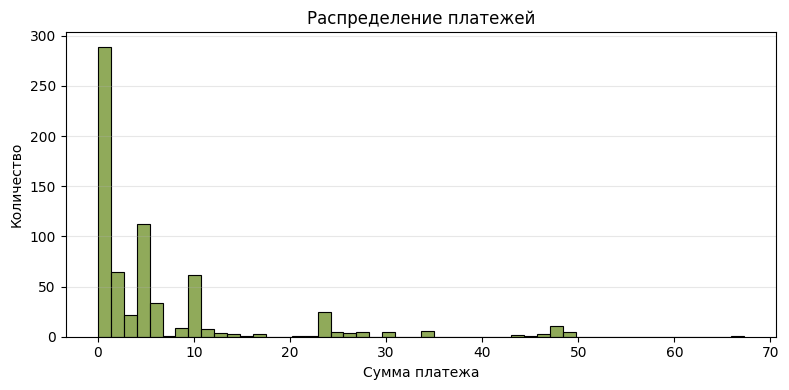

In [42]:
plt.figure(figsize=(8, 4))
sns.histplot(data=payers_with_tracked_campaigns, x='payment_amount', bins=50, kde=False, color='#6B8E23')
plt.title('Распределение платежей')
plt.xlabel('Сумма платежа')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Медианный платёж составляет 2.62, а средний 6.66, что указывает на асимметричное распределение: большинство транзакций -это микроплатежи, но присутствует значительное число более крупных платежей, существенно сдвигающих среднее вверх.

75% всех платежей не превышают 6.34, при этом максимум достигает 67.25, что более чем в 10 раз выше среднего. Это подчёркивает наличие редких, но ощутимых крупных транзакций.

Стандартное отклонение составляет 10.44, что является высоким относительно среднего значения. Это дополнительно подтверждает высокую изменчивость в поведении платящей аудитории.

Таким образом, основной вклад в выручку формируют немногие крупные плательщики, тогда как большинство пользователей совершают небольшие транзакции.

<br>

Какова суммарная выручка, полученная от пользователей, привлечённых через маркетинговые кампании?

In [43]:
payers_with_tracked_campaigns.payment_amount.sum().round(2)

4578.94

Ответ: 4578.94 $ (до вычета комиссии платёжных систем)

Посчитаем чистый доход.

In [44]:
# Добавим в датафрейм payers_with_tracked_campaigns данные со ставками комиссий
payers_with_tracked_campaigns = (
    payers_with_tracked_campaigns
    .merge(
        persents_df[['payment_types', 'payment_fee_rate']].dropna(),
        on='payment_types',
        how='inner'
    ))

# Переведем ставки комиссии в коэффициенты
payers_with_tracked_campaigns['payment_fee_rate'] = (payers_with_tracked_campaigns['payment_fee_rate'] / 100)

# Рассчитаем размеры платежей за вычетом комиссий платёжных систем
payers_with_tracked_campaigns['net_revenue'] = (payers_with_tracked_campaigns['payment_amount'] * (1 - payers_with_tracked_campaigns['payment_fee_rate']))

payers_with_tracked_campaigns

,payment_date,payment_types,payment_amount,account_id,payment_fee_rate,net_revenue
0,2021-01-01 15:10:26,Payment_system_5,2.45,3861811,0.24,1.8620
1,2021-01-01 15:22:00,Payment_system_5,2.45,3861811,0.24,1.8620
2,2021-01-01 17:16:09,Payment_system_5,9.62,3844647,0.24,7.3112
3,2021-01-01 17:17:45,Payment_system_5,9.62,3844647,0.24,7.3112
4,2021-01-02 01:08:32,Payment_system_5,0.96,3845613,0.24,0.7296
...,...,...,...,...,...,...
683,2021-12-29 17:14:22,Payment_system_4,2.62,3924840,0.00,2.6200
684,2021-12-29 18:55:43,Payment_system_4,0.10,3924840,0.00,0.1000
685,2021-12-29 21:22:10,Payment_system_4,0.31,3924840,0.00,0.3100
686,2021-12-30 08:15:58,Payment_system_4,0.38,3924840,0.00,0.3800


In [45]:
payers_with_tracked_campaigns.net_revenue.sum().round(2)

3553.59

Чистый доход со всех маркетинговых кампаний составляет 3553.59$.

Посмотрим на него в разрезе платёжных систем.

In [46]:
cost_sum_per_ps = payers_with_tracked_campaigns.groupby('payment_types').agg(payment_amount_sum = ('payment_amount','sum'), net_revenue_sum = ('net_revenue', 'sum')).round(2)
cost_sum_per_ps['comission'] = cost_sum_per_ps.payment_amount_sum - cost_sum_per_ps.net_revenue_sum
cost_sum_per_ps

,payment_amount_sum,net_revenue_sum,comission
payment_types,,,
Payment_system_1,265.02,210.16,54.86
Payment_system_2,167.70,142.54,25.16
Payment_system_4,207.34,207.34,0.00
Payment_system_5,3938.88,2993.55,945.33


Payment_system_5 обрабатывает наибольший объём выручки, несмотря на высокую комиссию (24%). Вероятно, за счёт популярности, удобства или широкой доступности для пользователей.

Payment_system_4 - самая выгодная с точки зрения экономики: комиссия отсутствует, что повышает чистую маржинальность транзакций, проходящих через неё.

Остальные платёжные системы используются значительно реже, а Payment_system_3 вовсе не задействована, что логично при комиссии в 58.5%.

In [47]:
# Наконец, объединяем плательщиков с регистрациями по account_id.
# Оставляем только тех, кто прошёл через маркетинговую кампанию (inner join).
payers_with_tracked_campaigns = (
        payers_with_tracked_campaigns.merge(
        reg_df,
        on='account_id',
        how='inner'
    ))
payers_with_tracked_campaigns

,payment_date,payment_types,payment_amount,account_id,payment_fee_rate,net_revenue,created_date,campaign
0,2021-01-01 15:10:26,Payment_system_5,2.45,3861811,0.24,1.8620,2021-01-07,RUS_MS1_purchase
1,2021-01-01 15:22:00,Payment_system_5,2.45,3861811,0.24,1.8620,2021-01-07,RUS_MS1_purchase
2,2021-01-01 17:16:09,Payment_system_5,9.62,3844647,0.24,7.3112,2021-01-01,BRA_MS1_install
3,2021-01-01 17:17:45,Payment_system_5,9.62,3844647,0.24,7.3112,2021-01-01,BRA_MS1_install
4,2021-01-02 01:08:32,Payment_system_5,0.96,3845613,0.24,0.7296,2021-01-02,RUS_MS1_purchase
...,...,...,...,...,...,...,...,...
683,2021-12-29 17:14:22,Payment_system_4,2.62,3924840,0.00,2.6200,2021-01-29,RUS_MS1_install
684,2021-12-29 18:55:43,Payment_system_4,0.10,3924840,0.00,0.1000,2021-01-29,RUS_MS1_install
685,2021-12-29 21:22:10,Payment_system_4,0.31,3924840,0.00,0.3100,2021-01-29,RUS_MS1_install
686,2021-12-30 08:15:58,Payment_system_4,0.38,3924840,0.00,0.3800,2021-01-29,RUS_MS1_install


Проверим датафрейм "payers_with_tracked_campaigns" на нарушение логики.

In [48]:
anomalies_df = payers_with_tracked_campaigns[payers_with_tracked_campaigns['payment_date'] < payers_with_tracked_campaigns['created_date']]
anomalies_df.shape[0]

18

In [49]:
anomalies_df['campaign'].value_counts()

campaign
BRA_MS1_install     6
RUS_MS1_purchase    5
RUS_MS1_install     3
UKR_MS1_purchase    3
UKR_MS1_install     1
Name: count, dtype: int64

In [50]:
anomalies_df['payment_types'].value_counts()

payment_types
Payment_system_5    12
Payment_system_4     4
Payment_system_1     2
Name: count, dtype: int64

In [51]:
anomalies_df.groupby('campaign').agg(net_revenue_sum = ('net_revenue', 'sum'))

,net_revenue_sum
campaign,
BRA_MS1_install,5.75833
RUS_MS1_install,7.67122
RUS_MS1_purchase,28.91040
UKR_MS1_install,0.72960
UKR_MS1_purchase,16.68960


In [52]:
anomalies_df['net_revenue'].sum().round(2)

59.76

In [53]:
anomalies_df.account_id.nunique()

10

🚨⚠️ В 5 рекламных кампаниях и 3 платёжных системах зафиксированы 18 аномальных транзакций от 10 пользователей на общую сумму $59.76, в которых дата платежа предшествует дате регистрации. Такое поведение противоречит логике пользовательского пути и, вероятнее всего, связано с ошибками в данных.

Надо разбираться. Я бы выгрузил эти 18 записей для дальнейшего аудита.

🚨⚠️ Данная находка может оказать влияние на сумму дохода и расчёт срока окупаемости.

**В данном случае лучше недооценить, чем переоценить.** Думаю, что эти записи стоит исключить из анализа. Лучше заложиться на более консервативные оценки: пусть фактическая прибыль окажется выше расчётной, а реальный срок окупаемости - короче прогнозируемого, чем наоборот.

In [54]:
# Отфильтруем данные записи
payers_with_tracked_campaigns = payers_with_tracked_campaigns[payers_with_tracked_campaigns['payment_date'] >= payers_with_tracked_campaigns['created_date']].reset_index(drop = True)
payers_with_tracked_campaigns 

,payment_date,payment_types,payment_amount,account_id,payment_fee_rate,net_revenue,created_date,campaign
0,2021-01-01 17:16:09,Payment_system_5,9.62,3844647,0.24,7.3112,2021-01-01,BRA_MS1_install
1,2021-01-01 17:17:45,Payment_system_5,9.62,3844647,0.24,7.3112,2021-01-01,BRA_MS1_install
2,2021-01-02 01:08:32,Payment_system_5,0.96,3845613,0.24,0.7296,2021-01-02,RUS_MS1_purchase
3,2021-01-02 13:21:20,Payment_system_5,0.96,3843913,0.24,0.7296,2021-01-01,RUS_MS1_purchase
4,2021-01-03 16:06:22,Payment_system_5,0.96,3849559,0.24,0.7296,2021-01-03,BRA_MS1_purchase
...,...,...,...,...,...,...,...,...
665,2021-12-29 17:14:22,Payment_system_4,2.62,3924840,0.00,2.6200,2021-01-29,RUS_MS1_install
666,2021-12-29 18:55:43,Payment_system_4,0.10,3924840,0.00,0.1000,2021-01-29,RUS_MS1_install
667,2021-12-29 21:22:10,Payment_system_4,0.31,3924840,0.00,0.3100,2021-01-29,RUS_MS1_install
668,2021-12-30 08:15:58,Payment_system_4,0.38,3924840,0.00,0.3800,2021-01-29,RUS_MS1_install


In [55]:
# Количество платящих пользователей
payers_with_tracked_campaigns.account_id.nunique()

195

In [56]:
# Количество платящих пользователей c разбивкой по кампаниям
payers_df = payers_with_tracked_campaigns.groupby('campaign').account_id.nunique().reset_index(name = 'payers')
payers_df

,campaign,payers
0,BRA_MS1_install,25
1,BRA_MS1_purchase,18
2,BRA_MS2_install,6
3,ENG_MS2_install,4
4,RUS_MS1_install,50
5,RUS_MS1_purchase,48
6,UKR_MS1_install,33
7,UKR_MS1_purchase,11


Всего у нас 195 пользователей, которые совершили хотя бы один платёж.

Из данных видно, что наибольшее число покупок приходится на кампанию RUS_MS1_install -- 50 и RUS_MS1_purchase -- 48. 

### Посмотрим, как распределяется выручка по кампаниям


In [57]:
# Рассчитаем комиссию платёжных систем и ее процент в каждой кампании
cost_sum_per_campaign = payers_with_tracked_campaigns.groupby('campaign').agg(payment_amount_sum = ('payment_amount','sum'), net_revenue_sum = ('net_revenue', 'sum')).round(2)
cost_sum_per_campaign['comission'] = cost_sum_per_campaign.payment_amount_sum  - cost_sum_per_campaign.net_revenue_sum
cost_sum_per_campaign['comission_rate'] = (cost_sum_per_campaign.comission / cost_sum_per_campaign.payment_amount_sum ).round(2)
cost_sum_per_campaign.reset_index(inplace=True)

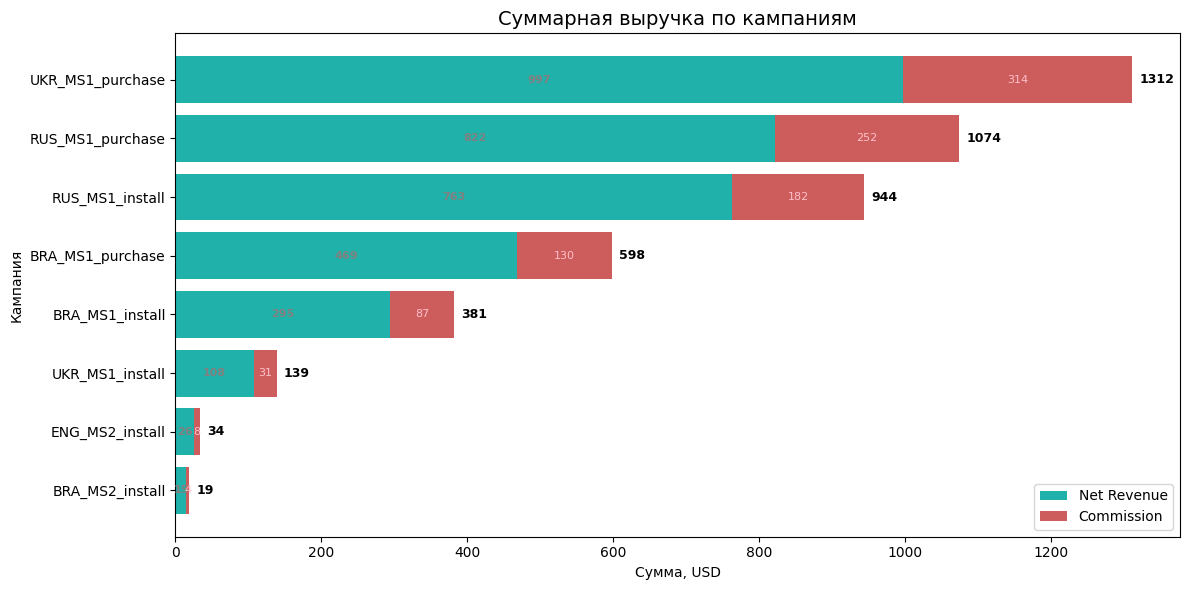

In [58]:
# Сортируем по общей сумме (net + commission)
plot_df = cost_sum_per_campaign.copy()
plot_df['total'] = plot_df['net_revenue_sum'] + plot_df['comission']
plot_df = plot_df.sort_values('total', ascending=True).reset_index()

# Цвета
net_color = '#20B2AA'
commission_color = '#CD5C5C'

# Построение графика
plt.figure(figsize=(12, 6))
plt.barh(plot_df['campaign'], plot_df['net_revenue_sum'], label='Net Revenue', color=net_color)
plt.barh(plot_df['campaign'], plot_df['comission'], left=plot_df['net_revenue_sum'], label='Commission', color=commission_color)

# Подписи
for i, (net, comm) in enumerate(zip(plot_df['net_revenue_sum'], plot_df['comission'])):
    total = net + comm
    plt.text(net / 2, i, f'{net:.0f}', va='center', ha='center', color='Grey', fontsize=8, fontweight='bold')
    plt.text(net + comm / 2, i, f'{comm:.0f}', va='center', ha='center', color='pink', fontsize=8)
    plt.text(total + 10, i, f'{total:.0f}', va='center', ha='left', fontsize=9, fontweight='bold')

plt.title('Суммарная выручка по кампаниям', fontsize=14)
plt.ylabel('Кампания')
plt.xlabel('Сумма, USD')
plt.legend()
plt.tight_layout()
plt.show()

Кампания UKR_MS1_purchase принесла наибольшую чистую выручку (997$), за ней - RUS_MS1_purchase (822$).

Интересно, что доля комиссии по всем кампаниям отличаются не сильно: от 19 до 24% от суммы.

Комиссии существенно снижают чистую выручку - это важно учитывать при расчёте ROI.

### А теперь посмотрим на суммарную выручку по кампаниям с разбивкой по платёжным системам 

In [59]:
summary_df = payers_with_tracked_campaigns.groupby(['campaign','payment_types']).agg(payment_amount_sum = ('payment_amount','sum'), net_revenue_sum = ('net_revenue', 'sum')).round(2)
summary_df['comission'] = summary_df.payment_amount_sum - summary_df.net_revenue_sum
summary_df['comission_rate'] = (summary_df.comission / summary_df.payment_amount_sum).round(2)
summary_df

payment_amount_sum  net_revenue_sum  \
campaign         payment_types                                           
BRA_MS1_install  Payment_system_1               51.60            40.92   
                 Payment_system_2               13.51            11.48   
                 Payment_system_4                7.33             7.33   
                 Payment_system_5              308.95           234.80   
BRA_MS1_purchase Payment_system_2              149.20           126.82   
                 Payment_system_4                1.04             1.04   
                 Payment_system_5              448.25           340.67   
BRA_MS2_install  Payment_system_2                4.99             4.24   
                 Payment_system_4                0.79             0.79   
                 Payment_system_5               13.38            10.17   
ENG_MS2_install  Payment_system_4                0.15             0.15   
                 Payment_system_5               33.52            25.48   
RUS_MS1_install  Payment_system_1              181.68           144.07   
                 Payment_system_4              163.13           163.13   
                 Payment_system_5              599.62           455.71   
RUS_MS1_purchase Payment_system_1                1.65             1.31   
                 Payment_system_4               23.41            23.41   
                 Payment_system_5             1049.19           797.38   
UKR_MS1_install  Payment_system_1               16.51            13.09   
                 Payment_system_4                7.05             7.05   
                 Payment_system_5              115.08            87.46   
UKR_MS1_purchase Payment_system_1                8.03             6.37   
                 Payment_system_4                0.61             0.61   
                 Payment_system_5             1303.09           990.35   

                                   comission  comission_rate  
campaign         payment_types                                
BRA_MS1_install  Payment_system_1      10.68            0.21  
                 Payment_system_2       2.03            0.15  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5      74.15            0.24  
BRA_MS1_purchase Payment_system_2      22.38            0.15  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5     107.58            0.24  
BRA_MS2_install  Payment_system_2       0.75            0.15  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5       3.21            0.24  
ENG_MS2_install  Payment_system_4       0.00            0.00  
                 Payment_system_5       8.04            0.24  
RUS_MS1_install  Payment_system_1      37.61            0.21  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5     143.91            0.24  
RUS_MS1_purchase Payment_system_1       0.34            0.21  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5     251.81            0.24  
UKR_MS1_install  Payment_system_1       3.42            0.21  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5      27.62            0.24  
UKR_MS1_purchase Payment_system_1       1.66            0.21  
                 Payment_system_4       0.00            0.00  
                 Payment_system_5     312.74            0.24

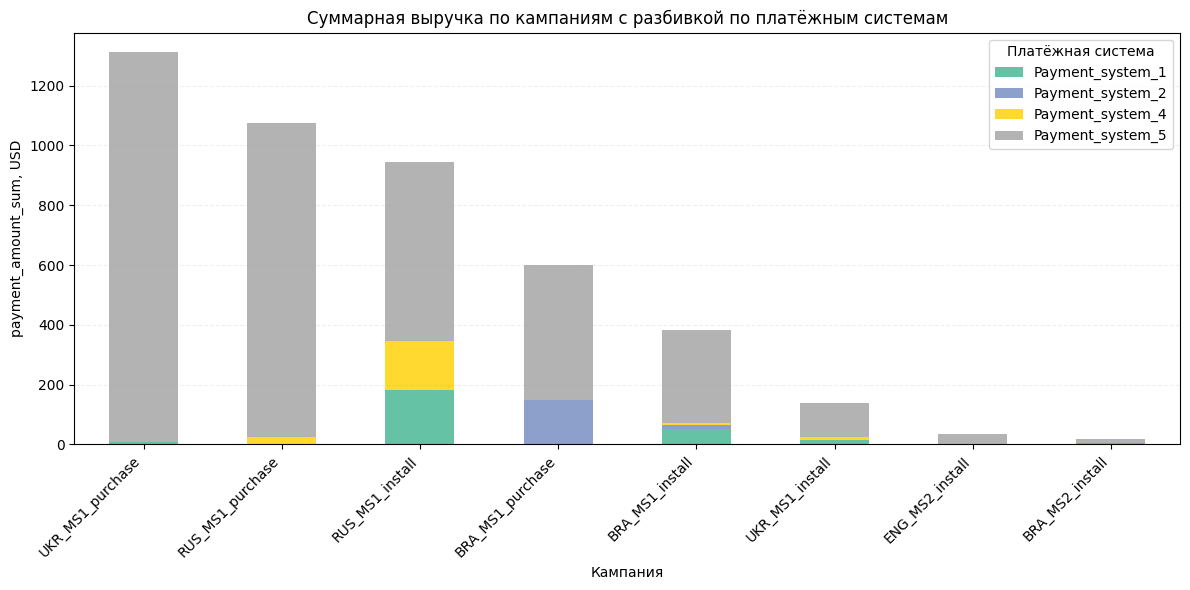

In [60]:
# Сброс индексов
plot_df = summary_df.reset_index()

# Сводная таблица: строки - кампании, столбцы - платёжные системы, значения - real_cost_sum
pivot_df = plot_df.pivot_table(
    index='campaign',
    columns='payment_types',
    values='payment_amount_sum',
    aggfunc='sum',
    fill_value=0
)

# Добавим столбец total для сортировки
pivot_df['total'] = pivot_df.sum(axis=1)

# Сортировка от большего к меньшему
pivot_df = pivot_df.sort_values('total', ascending=False).drop(columns='total')

# Построение графика
pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='Set2'
)

plt.title('Суммарная выручка по кампаниям с разбивкой по платёжным системам')
plt.xlabel('Кампания')
plt.ylabel('payment_amount_sum, USD')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.legend(title='Платёжная система')
plt.tight_layout()
plt.show()

Наиболее значимую часть выручки в каждой рекламной кампании обеспечивают транзакции через Payment_system_5, но при этом именно она даёт наибольшую комиссию - до 24% от суммы. В то же время Payment_system_4 обеспечивает чистую выручку без потерь, но участвует в меньшем числе платежей.

Структура платежей существенно различается по кампаниям: где-то больше охвата приходится на безкомиссионные каналы, а где-то почти вся выручка проходит через систему с высокой комиссией. Это подчёркивает важность не только привлечения трафика, но и оптимального распределения платёжных каналов.

<br>

### **Подведём ИТОГИ EDA**

* Каналы: **2**
* Кампании: **8**
* Платёжных систем: **5**
* Всего транзакций: **670** (с учётом удаления аномалий)
* Платящих пользователей: **195** (с учётом удаления аномалий)
* Количество регистраций. Выявлено расхождение между заявленными и фактически рассчитанными регистрациями:
   * По отчёту Богдана: **32 065** установок
   * По расчётам на основе registrations.csv: **34 430** установок (с учётом удаления аномалий)  
   * Отклонение: **2365** установок (примерно 7.4%). Это расхождение может быть связано с некорректной фильтрацией данных, ошибками при присвоении кампаний или расхождениями в источниках выгрузки.

<br>

🚨 **Выявленные аномалии в данных**

1. **registrations.csv:** 
   * 3 пропущенных значения в колонке account_id. Эти записи были исключены - они относятся к органическому трафику, не участвующему в анализе.
   * Временной диапазон файла заканчивается на '2021-01-31 00:00:00' - это означает, что все события, произошедшие 31 января после полуночи, могли быть упущены. В том числе это может повлиять на платёжные и поведенческие метрики.

2. **payments.csv:**  
   * 4 полных дубликата транзакций - удалены.
   * 20 транзакций с нулевой суммой - исключены из анализа.
   * 18 аномальных транзакций от 10 пользователей, где дата платежа предшествует дате регистрации - исключены. Общая сумма таких транзакций: 59.76$.

<br>

**Рекомендации:**    
1. Оптимизация работы с платёжными системами. Комиссия в ряде случаев съедает до 25% выручки.
2. Изучить пики и спады в динамике регистраций по всем кампаниям. Возможно, там скрываются инсайты.
3. Уточнить временные границы выгрузки: особенно важно убедиться, что данные за 31 января не были отсечены.


⚠️ Для более детального анализа не хватает контекста и данных.

**Пожалуй, на этом завершаем EDA и переходим к аналитической части проекта.** 

<br>
 
# **Поиск ответов на поставленные на вопросы**

In [61]:
# Слегка доработаем и переиспользуем уже собранный на стадии EDA датафрейм.

df = payers_with_tracked_campaigns

# Добавим возраст аккаунта на момент платежа
df['days_since_reg'] = (df['payment_date'] - df['created_date']).dt.days

df.head(2)

,payment_date,payment_types,payment_amount,account_id,payment_fee_rate,net_revenue,created_date,campaign,days_since_reg
0,2021-01-01 17:16:09,Payment_system_5,9.62,3844647,0.24,7.3112,2021-01-01,BRA_MS1_install,0
1,2021-01-01 17:17:45,Payment_system_5,9.62,3844647,0.24,7.3112,2021-01-01,BRA_MS1_install,0


In [62]:
# Группируем по кампании и возрасту аккаунта
base_df = df.groupby(['campaign', 'days_since_reg']).agg({ 'payment_amount': 'sum', 'net_revenue':'sum'}).reset_index()
base_df.head()

,campaign,days_since_reg,payment_amount,net_revenue
0,BRA_MS1_install,0,19.24,14.6224
1,BRA_MS1_install,1,0.25,0.2500
2,BRA_MS1_install,2,0.23,0.2300
3,BRA_MS1_install,3,5.58,4.2408
4,BRA_MS1_install,5,0.11,0.1100


Поскольку данных немного и встречаются дни без платежей, необходимо построить каркас по всем дням - это обеспечит корректный расчёт накопительных метрик.

Сначала я пытался объединить каркас с развёрнутой pivot-таблицей base_df, но такой формат не позволяет одновременно сохранять несколько метрик (net и gross доход). 

Поскольку в задании не уточнено, какой именно CARPU ожидает получить и **для чего** (на базе net или gross выручки), я рассчитаю обе версии:
* CARPU_net  = cumulative_net_revenue/ installs
* CARPU_gross = cumulative_payment_amount/ installs


In [63]:
# Создадим каркас

# Создадим df с уникальными кампаниия и ключём для кросс-джойна
campaigns = pd.DataFrame({'campaign': base_df['campaign'].unique(),'key' : 1})

# Все дни от 0 до максимального
days = pd.DataFrame({'days_since_reg': range(df['days_since_reg'].max() + 1), 'key' : 1})

# Декартово произведение 
skeleton_df = campaigns.merge(days, on='key').drop(columns='key')

skeleton_df

,campaign,days_since_reg
0,BRA_MS1_install,0
1,BRA_MS1_install,1
2,BRA_MS1_install,2
3,BRA_MS1_install,3
4,BRA_MS1_install,4
...,...,...
2867,UKR_MS1_purchase,354
2868,UKR_MS1_purchase,355
2869,UKR_MS1_purchase,356
2870,UKR_MS1_purchase,357


In [64]:
base_df = skeleton_df.merge(
    base_df, 
    on=['campaign', 'days_since_reg'],
    how='left'
).fillna(0)

In [65]:
base_df

,campaign,days_since_reg,payment_amount,net_revenue
0,BRA_MS1_install,0,19.24,14.6224
1,BRA_MS1_install,1,0.25,0.2500
2,BRA_MS1_install,2,0.23,0.2300
3,BRA_MS1_install,3,5.58,4.2408
4,BRA_MS1_install,4,0.00,0.0000
...,...,...,...,...
2867,UKR_MS1_purchase,354,0.00,0.0000
2868,UKR_MS1_purchase,355,0.00,0.0000
2869,UKR_MS1_purchase,356,0.00,0.0000
2870,UKR_MS1_purchase,357,0.00,0.0000


In [66]:
# Удаляем из данных по регистрации 10 пользователей с аномальными транзакциями, выявленными в EDA.
reg_df = reg_df[~reg_df['account_id'].isin(anomalies_df['account_id'].unique())].reset_index(drop=True)

In [67]:
real_reg_df = reg_df['campaign'].value_counts().reset_index(name = "real_installs")
real_reg_df

,campaign,real_installs
0,RUS_MS1_install,12646
1,BRA_MS1_install,11459
2,UKR_MS1_install,6789
3,RUS_MS1_purchase,1580
4,BRA_MS1_purchase,1139
5,ENG_MS2_install,407
6,UKR_MS1_purchase,258
7,BRA_MS2_install,152


In [68]:
# Добавляем количество регистраций в df base_df
base_df = base_df.merge(real_reg_df, on='campaign', how='inner')

#### Считаем кумулятивную выручку и ARPU

In [69]:
base_df['cum_net_rev'] = base_df.groupby('campaign')['net_revenue'].cumsum()
base_df['cum_gross_rev'] = base_df.groupby('campaign')['payment_amount'].cumsum()
base_df['carpu_net'] = base_df['cum_net_rev'] / base_df['real_installs']
base_df['carpu_gross'] = base_df['cum_gross_rev'] / base_df['real_installs']

base_df

,campaign,days_since_reg,payment_amount,net_revenue,real_installs,cum_net_rev,cum_gross_rev,carpu_net,carpu_gross
0,BRA_MS1_install,0,19.24,14.6224,11459,14.62240,19.24,0.001276,0.001679
1,BRA_MS1_install,1,0.25,0.2500,11459,14.87240,19.49,0.001298,0.001701
2,BRA_MS1_install,2,0.23,0.2300,11459,15.10240,19.72,0.001318,0.001721
3,BRA_MS1_install,3,5.58,4.2408,11459,19.34320,25.30,0.001688,0.002208
4,BRA_MS1_install,4,0.00,0.0000,11459,19.34320,25.30,0.001688,0.002208
...,...,...,...,...,...,...,...,...,...
2867,UKR_MS1_purchase,354,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225
2868,UKR_MS1_purchase,355,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225
2869,UKR_MS1_purchase,356,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225
2870,UKR_MS1_purchase,357,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225


In [70]:
# На основе budget_df начнём собирать финальную таблицу.
result_df = budget_df[['tag', 'campaign_type', 'plan', 'spend_actual', 'deviation', 'bogdan_installs', 'bogdan_cpi']]

result_df = (
    result_df
    .merge(
        real_reg_df,
        left_on='tag',
        right_on='campaign',
        how='inner'
    ).drop(columns='campaign')).rename(columns = {'tag':'campaign'})

result_df['real_cpi'] = (result_df['spend_actual'] / result_df['real_installs']).round(3)

result_df.head() 

,campaign,campaign_type,plan,spend_actual,deviation,bogdan_installs,bogdan_cpi,real_installs,real_cpi
0,BRA_MS1_install,install,100,99.12,0.88,10460,0.009,11459,0.009
1,BRA_MS1_purchase,purchase,400,398.67,1.33,1081,0.369,1139,0.350
2,RUS_MS1_install,install,200,246.30,-46.30,11894,0.021,12646,0.019
3,RUS_MS1_purchase,purchase,500,616.77,-116.77,1441,0.428,1580,0.390
4,UKR_MS1_install,install,100,99.43,0.57,6424,0.015,6789,0.015


In [71]:
# Для расчёта срока окупаемости добавим в таблицу 'base_df' рассчитанный ранее CPI и фактические затраты на компанию.
base_df = base_df.merge(result_df[['campaign', 'real_cpi', 'spend_actual']], on='campaign', how='inner')

base_df.head()

,campaign,days_since_reg,payment_amount,net_revenue,real_installs,cum_net_rev,cum_gross_rev,carpu_net,carpu_gross,real_cpi,spend_actual
0,BRA_MS1_install,0,19.24,14.6224,11459,14.6224,19.24,0.001276,0.001679,0.009,99.12
1,BRA_MS1_install,1,0.25,0.2500,11459,14.8724,19.49,0.001298,0.001701,0.009,99.12
2,BRA_MS1_install,2,0.23,0.2300,11459,15.1024,19.72,0.001318,0.001721,0.009,99.12
3,BRA_MS1_install,3,5.58,4.2408,11459,19.3432,25.30,0.001688,0.002208,0.009,99.12
4,BRA_MS1_install,4,0.00,0.0000,11459,19.3432,25.30,0.001688,0.002208,0.009,99.12


### Расчитаем срок окупаемости рекламных кампаний двумя способами: 


**Метод 1 (фактическая окупаемость):**    
Находим минимальный день, на котором суммарный доход кампании превысит или сравнятся с фактическими расходами (net_revenue_sum >= spend_actual).
Этот метод отражает реальный возврат инвестиций в абсолютных значениях.

**Метод 2:**   
Найдем минимальный день, на котором carpu_net >= cpi. Преимущество подхода в том, что он нормализует доход на одного пользователя, что удобно для сравнения эффективности кампаний между собой. Кроме того, CARPU при увеличении числа дней стремится к LTV, что делает метрику интерпретируемой и в долгосрочной перспективе.

Сравним результаты обоих подходов.

In [72]:
# Поиск дня, когда cumulative_net >= spend_actual
payback_days_v1 = base_df[base_df['cum_net_rev'] >= base_df['spend_actual']].groupby('campaign')['days_since_reg'].min().reset_index()
payback_days_v1.columns = ['campaign', 'payback_day_v1']
payback_days_v1.sort_values('payback_day_v1', inplace= True)
payback_days_v1 = payback_days_v1.reset_index(drop=True)
payback_days_v1

# Поиск дня, когда СARPU_net >= CPI
payback_days_v2 = base_df[base_df['carpu_net'] >= base_df['real_cpi']].groupby('campaign')['days_since_reg'].min().reset_index()
payback_days_v2.columns = ['campaign', 'payback_day_v2']
payback_days_v2.sort_values('payback_day_v2', inplace= True)
payback_days_v2 = payback_days_v2.reset_index(drop=True)
payback_days_v2


# Объединим и рассчитаем разницу
payback_days = payback_days_v1.merge(payback_days_v2, on='campaign', how='inner')
payback_days['delta'] = payback_days['payback_day_v1'] - payback_days['payback_day_v2'] 

# Т.к. расчитанные данные будут добавлены в финальную таблицу - переименуем их.
payback_days.rename(columns={
    'payback_day_v1': 'Payback (cum_net_rev >= spend)',
    'payback_day_v2': 'Payback (carpu_net >= cpi)'
}, inplace=True)

payback_days

,campaign,Payback (cum_net_rev >= spend),Payback (carpu_net >= cpi),delta
0,BRA_MS1_install,51,58,-7
1,RUS_MS1_install,118,111,7
2,UKR_MS1_purchase,161,161,0
3,BRA_MS1_purchase,191,191,0
4,UKR_MS1_install,259,289,-30
5,RUS_MS1_purchase,273,273,0


**Какой метод оптимальнее?**

Метод 1 (cum_net_rev >= spend) даёт реальную окупаемость бюджета - то есть момент, когда вложенные деньги полностью вернулись. Он точнее отражает возврат инвестиций в абсолютных значениях, но не всегда подходит для сравнений между кампаниями, т.к. не учитывает их масштаб и охват.

Метод 2 (carpu_net >= cpi) больше подходит для сравнительного анализа между кампаниями с разным масштабом и охватом и отслеживания долгосрочной монетизации, так как CARPU стремится к LTV.


**Будем ориентироваться в первую очередь на Метод 1 (cum_net_rev >= spend) - как более точный и финансово ориентированный.**

In [73]:
payback_days = payback_days[['campaign', 'Payback (cum_net_rev >= spend)']].rename(columns={'Payback (cum_net_rev >= spend)': 'payback_days'})

# Соберём финальный DF
result_df =(result_df
            .merge(cost_sum_per_campaign, on='campaign', how='inner')
            .merge(payers_df, on='campaign', how='inner')
            .merge(payback_days, on='campaign', how='left')
            )

Имеющиеся данные позволяют расчитать ещё несколько метрик, характеризующих **качество привлеченного компаниями трафика**. Так сделаем это! <a id="011"></a>

In [74]:
# ARPU
result_df['ARPU'] = (result_df['payment_amount_sum'] / result_df['real_installs']).round(2)

# ARPPU
result_df['ARPPU'] = (result_df['payment_amount_sum'] / result_df['payers']).round(2)

# ROI
result_df['ROI'] = ((result_df['net_revenue_sum'] - result_df['spend_actual']) / result_df['spend_actual']).round(2)

# Paying Share
result_df['paying_share'] = (result_df['payers'] / result_df['real_installs']).round(3)

result_df.head(2)

,campaign,campaign_type,plan,spend_actual,deviation,bogdan_installs,bogdan_cpi,real_installs,real_cpi,payment_amount_sum,net_revenue_sum,comission,comission_rate,payers,payback_days,ARPU,ARPPU,ROI,paying_share
0,BRA_MS1_install,install,100,99.12,0.88,10460,0.009,11459,0.009,381.39,294.53,86.86,0.23,25,51.0,0.03,15.26,1.97,0.002
1,BRA_MS1_purchase,purchase,400,398.67,1.33,1081,0.369,1139,0.350,598.49,468.53,129.96,0.22,18,191.0,0.53,33.25,0.18,0.016


In [75]:
# Добавим строку с итогами
summary_row = {
    'campaign': 'Total',
    'plan': result_df['plan'].sum(),
    'spend_actual': result_df['spend_actual'].sum(),
    'deviation': result_df['deviation'].sum(),
    'bogdan_installs': result_df['bogdan_installs'].sum(),
    'real_installs': result_df['real_installs'].sum(),
    'payment_amount_sum': result_df['payment_amount_sum'].sum(),
    'net_revenue_sum': result_df['net_revenue_sum'].sum(),
    'comission': result_df['comission'].sum(),
    'payers': result_df['payers'].sum()
}

# Добавим к датафрейму
result_df = pd.concat([result_df, pd.DataFrame([summary_row])], ignore_index=True)

# Для удобства восприятия изменим порядок колонок
new_order = [
    'campaign', 'campaign_type', 'plan', 'spend_actual', 'deviation',
    'bogdan_installs', 'bogdan_cpi',  
    'real_installs', 'real_cpi',
    'payers', 'paying_share',
    'payment_amount_sum', 'net_revenue_sum', 'comission', 'comission_rate',
    'ARPU', 'ARPPU', 'ROI', 'payback_days'
]

result_df = result_df[new_order]


result_df

,campaign,campaign_type,plan,spend_actual,deviation,bogdan_installs,bogdan_cpi,real_installs,real_cpi,payers,paying_share,payment_amount_sum,net_revenue_sum,comission,comission_rate,ARPU,ARPPU,ROI,payback_days
0,BRA_MS1_install,install,100,99.12,0.88,10460,0.009,11459,0.009,25,0.002,381.39,294.53,86.86,0.23,0.03,15.26,1.97,51.0
1,BRA_MS1_purchase,purchase,400,398.67,1.33,1081,0.369,1139,0.350,18,0.016,598.49,468.53,129.96,0.22,0.53,33.25,0.18,191.0
2,RUS_MS1_install,install,200,246.30,-46.30,11894,0.021,12646,0.019,50,0.004,944.43,762.91,181.52,0.19,0.07,18.89,2.10,118.0
3,RUS_MS1_purchase,purchase,500,616.77,-116.77,1441,0.428,1580,0.390,48,0.030,1074.25,822.10,252.15,0.23,0.68,22.38,0.33,273.0
4,UKR_MS1_install,install,100,99.43,0.57,6424,0.015,6789,0.015,33,0.005,138.64,107.60,31.04,0.22,0.02,4.20,0.08,259.0
5,UKR_MS1_purchase,purchase,500,348.13,151.87,242,1.439,258,1.349,11,0.043,1311.73,997.33,314.40,0.24,5.08,119.25,1.86,161.0
6,BRA_MS2_install,install,100,81.15,18.85,152,0.534,152,0.534,6,0.039,19.16,15.20,3.96,0.21,0.13,3.19,-0.81,NaN
7,ENG_MS2_install,install,100,99.95,0.05,371,0.269,407,0.246,4,0.010,33.67,25.63,8.04,0.24,0.08,8.42,-0.74,NaN
8,Total,NaN,2000,1989.52,10.48,32065,NaN,34430,NaN,195,NaN,4501.76,3493.83,1007.93,NaN,NaN,NaN,NaN,NaN


In [76]:
# В result_df в файл .xlsx для последующей подготовки отчёта по результам анализа.

result_df.to_excel('Marketing_Campaign_Analysis.xlsx', sheet_name='Sheet1', index=False)

### Ответы на вопросы Богдана

Итак, у нас есть все необходимые данные, чтобы ответить на вопросы Богдана. 

**1. Определение оптимального срока окупаемости рекламных кампаний**

In [77]:
payback_days = result_df[['campaign', 'payback_days']].drop(index=8).sort_values('payback_days', ascending=True).reset_index(drop = True)
payback_days

,campaign,payback_days
0,BRA_MS1_install,51.0
1,RUS_MS1_install,118.0
2,UKR_MS1_purchase,161.0
3,BRA_MS1_purchase,191.0
4,UKR_MS1_install,259.0
5,RUS_MS1_purchase,273.0
6,BRA_MS2_install,NaN
7,ENG_MS2_install,NaN


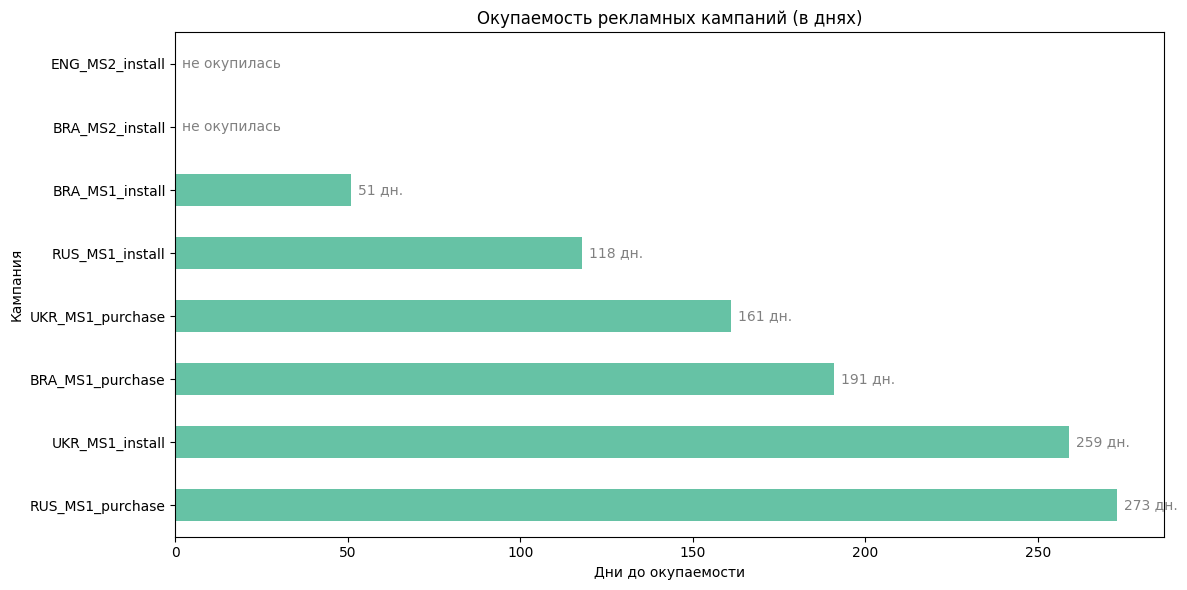

In [78]:
# Визуализируем
payback_days.sort_values('payback_days', ascending=False, inplace=True)
payback_days.set_index('campaign', inplace=True)

# Строим график
ax = payback_days.plot(
    kind='barh',
    figsize=(12, 6),
    colormap='Set2',
    legend=False,
    title='Окупаемость рекламных кампаний (в днях)'
)

# Добавляем подписи к каждой строке
for i, (value, label) in enumerate(zip(payback_days['payback_days'], payback_days.index)):
    if pd.notna(value):
        ax.text(value + 2, i, f'{int(value)} дн.', va='center', ha='left', color='gray')
    else:
        ax.text(2, i, 'не окупилась', va='center', ha='left', color='gray')

# Настройка осей и отображение
ax.set_xlabel('Дни до окупаемости')
ax.set_ylabel('Кампания')
plt.tight_layout()
plt.show()

Для каждой кампании был рассчитан день, на котором суммарный доход кампании стал равен или превысил фактические расходы на проведение кампании (net_revenue_sum >= spend_actual). Это и считается моментом окупаемости.

* Две кампании (BRA_MS2_install и ENG_MS2_install) за 2021 год так и не вышли в окупаемость.

* Самой быстрой оказалась кампания BRA_MS1_install - окупаемость достигнута на 51-й день.

* Кампании с акцентом на покупки окупаются дольше: например, UKR_MS1_purchase - на 161-й день, RUS_MS1_purchase - только на 273-й день.

* Дольше всех окупается RUS_MS1_purchase -- 273 дней

Такая разница в сроках окупаемости говорит о том, что тип кампании (установки / покупки), регион, качество трафика и поведение аудитории - всё это критически влияет на возврат инвестиций. В ряде случаев установочные кампании оказываются более оборачиваемыми.

**2. Рассчитать накопительный ARPU (average revenue per user) самой успешной рекламной кампании, оптимизированных под покупки, на 7, 14, 30 день жизни аккаунтов.**

Сперва определимся с самой успешной кампанией в purchase.

In [79]:
purchase_df = result_df[result_df['campaign_type'] == 'purchase']
purchase_df = purchase_df[
    ['campaign', 'spend_actual', 'real_installs', 'real_cpi', 'payers',
     'paying_share', 'payment_amount_sum', 'net_revenue_sum',
     'comission', 'comission_rate', 'ARPU', 'ARPPU', 'ROI', 'payback_days']]

purchase_df

,campaign,spend_actual,real_installs,real_cpi,payers,paying_share,payment_amount_sum,net_revenue_sum,comission,comission_rate,ARPU,ARPPU,ROI,payback_days
1,BRA_MS1_purchase,398.67,1139,0.350,18,0.016,598.49,468.53,129.96,0.22,0.53,33.25,0.18,191.0
3,RUS_MS1_purchase,616.77,1580,0.390,48,0.030,1074.25,822.10,252.15,0.23,0.68,22.38,0.33,273.0
5,UKR_MS1_purchase,348.13,258,1.349,11,0.043,1311.73,997.33,314.40,0.24,5.08,119.25,1.86,161.0


Анализ показал, что среди трёх purchase-кампаний наилучшие показатели эффективности продемонстрировала <span style="color:#008080"> **UKR_MS1_purchase**</span>:

* Срок окупаемости: 161 день - быстрее, чем у других purchase-кампаний;

* ARPU: 5.08$ - самый высокий доход на пользователя;

* ARPPU: 119.25$ - очень высокая монетизация среди платящих;

* Paying share: 4.3% - самая высокая доля платящих не только среди purchase-кампаний, но и среди всех восьми анализируемых;

* ROI: 1.86 - почти двукратная окупаемость вложений.



In [80]:
base_df

,campaign,days_since_reg,payment_amount,net_revenue,real_installs,cum_net_rev,cum_gross_rev,carpu_net,carpu_gross,real_cpi,spend_actual
0,BRA_MS1_install,0,19.24,14.6224,11459,14.62240,19.24,0.001276,0.001679,0.009,99.12
1,BRA_MS1_install,1,0.25,0.2500,11459,14.87240,19.49,0.001298,0.001701,0.009,99.12
2,BRA_MS1_install,2,0.23,0.2300,11459,15.10240,19.72,0.001318,0.001721,0.009,99.12
3,BRA_MS1_install,3,5.58,4.2408,11459,19.34320,25.30,0.001688,0.002208,0.009,99.12
4,BRA_MS1_install,4,0.00,0.0000,11459,19.34320,25.30,0.001688,0.002208,0.009,99.12
...,...,...,...,...,...,...,...,...,...,...,...
2867,UKR_MS1_purchase,354,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225,1.349,348.13
2868,UKR_MS1_purchase,355,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225,1.349,348.13
2869,UKR_MS1_purchase,356,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225,1.349,348.13
2870,UKR_MS1_purchase,357,0.00,0.0000,258,997.32619,1311.73,3.865605,5.084225,1.349,348.13


In [81]:
# Отфильтруем нужные нам значения
UKR_MS1_purchase_metrics = (base_df
                            .query("campaign == 'UKR_MS1_purchase' and days_since_reg in [7, 14, 30]")[['campaign', 'days_since_reg',
                                                'real_cpi', 'cum_net_rev', 'cum_gross_rev', 'carpu_gross', 'carpu_net']])
UKR_MS1_purchase_metrics['recoupment'] = (UKR_MS1_purchase_metrics.carpu_net / UKR_MS1_purchase_metrics.real_cpi).round(2)
UKR_MS1_purchase_metrics 

,campaign,days_since_reg,real_cpi,cum_net_rev,cum_gross_rev,carpu_gross,carpu_net,recoupment
2520,UKR_MS1_purchase,7,1.349,30.34739,39.44,0.152868,0.117626,0.09
2527,UKR_MS1_purchase,14,1.349,30.34739,39.44,0.152868,0.117626,0.09
2543,UKR_MS1_purchase,30,1.349,116.31859,152.56,0.591318,0.450847,0.33


Итак...    

Кампания UKR_MS1_purchase, оптимизированная под покупки, демонстрирует постепенный рост СARPU. На 7 день после регистрации пользователей чистый СARPU составил 0.12$, грязный СARPU - 0.15$. К 14 дню значения не изменились, что говорит об отсутствии новых оплат в этот период. Однако к 30 дню наблюдается значительный прирост: чистый СARPU достиг 0.45$, грязный - 0.59$. Что говорит о наличии «длинного хвоста» в монетизации - часть пользователей совершают покупки значительно позже регистрации.

С учётом стоимости привлечения одного пользователя (CPI = 1.35$), к 30 дню кампании удаётся вернуть около 33% затрат. Это говорит о потенциальной окупаемости при более длительном горизонте.

Посмотрим на СARPU в динамике.

In [82]:
UKR_MS1_purchase_metrics = (
    base_df.query("campaign == 'UKR_MS1_purchase' and (days_since_reg >= 0 and days_since_reg <= 60)")
           [['campaign', 'days_since_reg', 'real_cpi', 'carpu_gross', 'carpu_net']])

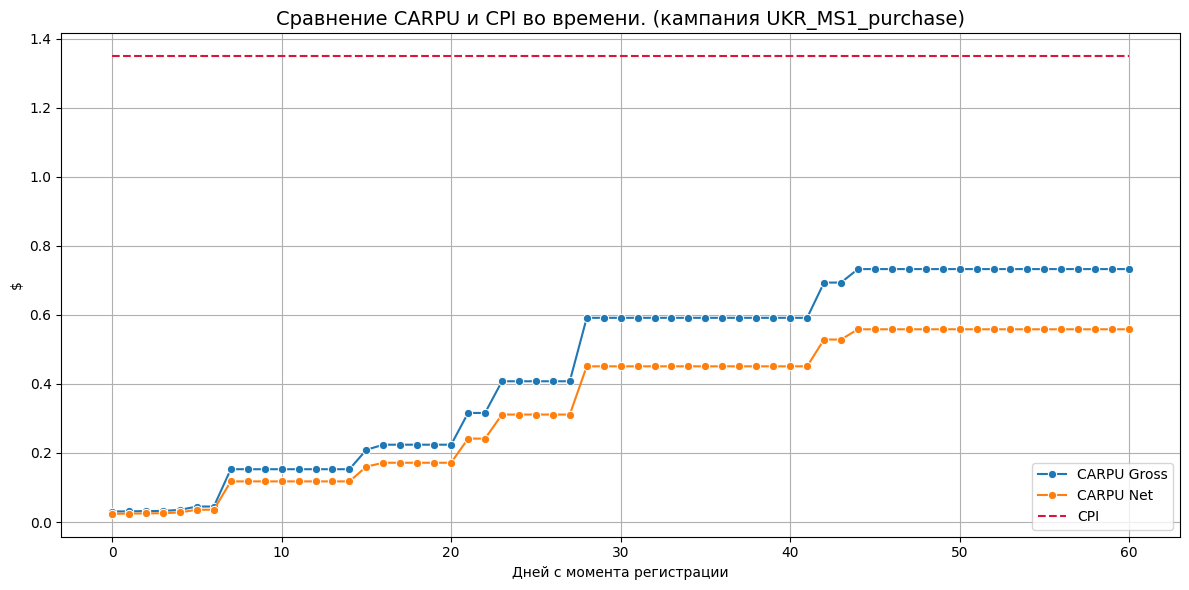

In [83]:
# Построим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=UKR_MS1_purchase_metrics, x='days_since_reg', y='carpu_gross', label='CARPU Gross', marker='o')
sns.lineplot(data=UKR_MS1_purchase_metrics, x='days_since_reg', y='carpu_net', label='CARPU Net', marker='o')
sns.lineplot(data=UKR_MS1_purchase_metrics, x='days_since_reg', y='real_cpi', label='CPI', linestyle='--', color='#DC143C')

plt.title("Сравнение CARPU и CPI во времени. (кампания UKR_MS1_purchase)", fontsize=14)
plt.xlabel("Дней с момента регистрации")
plt.ylabel("$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

График показывает, что рост CARPU происходит неравномерно и ступенчато, что может свидетельствовать о влиянии отдельных «китов» (крупных плательщиков) на монетизацию кампании. При этом общая динамика положительная - доход на пользователя растёт со временем.

На горизонте в 60 дней CARPU Net стабилизируется на уровне 0.56$, а CARPU Gross достигает 0.75$, что в обоих случаях не покрывает уровень CPI (1.35 $).

Ещё график наглядно иллюстрирует долю комиссий, съедающих существенную часть дохода. 

<br>

## **Метрики для оценки успешности кампаний на ранних стадиях:** 



1.<span style="color: #FF6861;"> **Retention rate (D1 / D3 / D7)**</span>  - одна из метрик, отражающая «удержание пользователей» игрой. Показывает, возвращаются ли пользователи после первого входа. Т.е. данная метрика напрямую связана с пользовательским опытом и качеством продукта, и его соответствием целевой аудитории.

Если коротко, то Retention показывает сколько людей (процент пользователей) вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт (Day 0).

**Бизнес-суть:** Чем дольше пользователь остается в проекте, тем выше вероятность совершения платежа, его размер и/или большее количество просматриваемой рекламы. Соответственно высокий уровень удержания пользователей напрямую влияет на доходность и успешность продукта. Если retention низкий уже на D1/D3 - скорее всего, трафик некачественный, либо есть проблемы с онбордингом или продуктом.

<span style="color: #B22222;"> Для расчёта не хватает данных.</span> 


<br>


2.<span style="color: #FF6861;"> **ARPU (ARPPU)** </span> 
- <span style="color: #FF6861;"> ARPU</span>  - средний доход на одного пользователя (включая и неплатящих) за определённый период времени.
- <span style="color: #FF6861;"> ARPPU</span> - средний доход только на одного платящего пользователя. Этот показатель учитывает только тех, кто сделал хотя бы один платёж. 

**Бизнес-суть:**  ARPU (ARPPU)  важен для оценки эффективности монетизации, так как показывает, насколько хорошо продукт генерирует доход с (платящих) пользователей. Он помогает понять их реакцию на ценность проекта и изменения в монетизационной стратегии.


<br> 


3.<span style="color: #FF6861;"> **CR в первый платеж (в окне 7 дней)**</span> - доля пользователей, совершивших хотя бы одну покупку в течение 7 дней с момента установки.

**Бизнес-суть:**
  * Позволяет оценить качество привлечённой аудитории: если пользователи быстро делают первый платёж - это сигнал, что они мотивированы и ценят продукт.
  * При высоком CR - кампания может окупаться быстрее и масштабироваться увереннее.
  * Если CR низкий - либо трафик некачественный, либо в продукте есть барьеры к покупке.

<br> 

4.<span style="color: #FF6861;"> **ROI (D7, D14, D30) и его вариации(ROAS, ROMI)**</span> - возврат инвестиций. Показывает, насколько эффективно вложенные средства приносят прибыль.

**Бизнес-суть:**  Позволяет понять идёт ли хоть какой-то возврат денег. Ранний ROI - это не итоговый результат, но сильный предиктор успеха. Даже если кампания ещё не вышла в плюс, можно сравнивать ROI по каналам и находить более эффективные.


<br>


5.<span style="color: #FF6861;">**ARPDAU / ARPWAU / ARPMAU**</span> - cредняя выручка на одного активного пользователя в день / неделю / месяц.
    
**Бизнес-суть:** Позволяет понять насколько хорошо монетизируются активные пользователи.  
   
<span style="color: #B22222;"> Для расчёта не хватает данных.</span> 


<br>



6.<span style="color: #FF6861;"> **Tutorial Retention Rate (Tutorial Completion Rate) / Tutorial Skip Rate**</span> - метрики прохождения Tutorial. Тут всё понятно.

**Бизнес-суть:**
Указывает на понятность и эффективность первого взаимодействия. Если тут "проседает" трафик, скорее всего, возникла путаница или потеря интереса, или нецелевой трафик.

<span style="color: #B22222;"> Для расчёта не хватает данных.</span> 


<br> 


7.<span style="color: #FF6861;"> **Выполнение ключевых действий в продукте. Воронка. (Product Event Funnel)**</span>

Примеры:
* просмотр магазина,
* прохождение 1 уровня,
* добавление товара в корзину.

**Бизнес-суть:**
Позволяет понять, насколько глубоко пользователи вовлекаются в продукт. Чем выше конверсии в ключевые события, тем выше шанс последующих оплат.

<span style="color: #B22222;"> Для расчёта не хватает данных.</span> 


<br> 


8.<span style="color: #FF6861;"> **Sessions per User**</span> - среднее количество сессий, которое пользователь инициирует за первые X дней.

**Бизнес-суть:**
Отражает уровень вовлечённости. Пользователь с 5–10 сессиями за первые 3 дня, скорее всего, заинтересован и имеет потенциал для монетизации.

<span style="color: #B22222;"> Для расчёта не хватает данных.</span> 


<br>


9.<span style="color: #FF6861;"> **Time to First Purchase**</span> - среднее количество времени от установки до первой покупки.

**Бизнес-суть:** Позволяет прогнозировать окупаемость. Если большая часть пользователей платит в первые 1–3 дня - окупаемость может быть быстрой, и кампанию можно масштабировать.


<br>


**Эти показатели дополняют стандартные метрики и позволяют оценить поведение пользователей и потенциал монетизации на раннем этапе.**

💡В игровом / маркетинговом анализе существует достаточно большое количество метрик, каждая из которых имеет свой фокус и значение. От Retention и ARPU до LTV, CARPU, Conversion и Paying Share - все эти показатели предоставляют информацию о разных аспектах взаимодействия пользователей с продуктом. Важно понимать, что для правильного анализа необходимо выбирать те метрики, которые наилучшим образом отражают текущие бизнес-цели и контекст.
Важно, чтобы выбранные показатели решали конкретные бизнес-задачи и имели практическую ценность. Именно этого принципа я придерживался при подборе метрик в данном разделе.

# Спасибо за интересное тестовое, было полезно поразмышлять над задачами! Хорошего дня! 😊🤝